In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt  

from sklearn import preprocessing
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE

import copy
import regex as re

In [2]:
loan_train = pd.read_csv("loan_train.csv")
loan_test = pd.read_csv("loan_test.csv")

In [3]:
# Set a random seed

random_seed = 94
np.random.seed(random_seed)

### Implementing SMOTE for imbalanced data

In [4]:
x = loan_train.loc[:, loan_train.columns != 'Label']
y = loan_train.loc[:, loan_train.columns == 'Label']

x_test = loan_test.loc[:, loan_test.columns != 'Label']
y_test = loan_test.loc[:, loan_test.columns == 'Label']

In [5]:
sm = SMOTE(random_state = 42)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = random_seed)

columns = x_train.columns

x_train_sm, y_train_sm = sm.fit_resample(x_train, y_train)
x_train_sm = pd.DataFrame(data = x_train_sm, columns = columns)
y_train_sm = pd.DataFrame(data = y_train_sm, columns = ['Label'])

In [6]:
print("\033[1m Length of oversampled data is", len(x_train_sm))
print("\033[1m Number of 'Good' in oversampled data", len(y_train_sm[y_train_sm['Label'] == 0]))
print("\033[1m Number of 'Bad'", len(y_train_sm[y_train_sm['Label'] == 1]))
print("\033[1m Proportion of 'Good' data in oversampled data is", len(y_train_sm[y_train_sm['Label'] == 0])/len(x_train_sm))
print("\033[1m Proportion of 'Bad' data in oversampled data is", len(y_train_sm[y_train_sm['Label'] == 1])/len(x_train_sm))

 Length of oversampled data is 242
 Number of 'Good' in oversampled data 121
 Number of 'Bad' 121
 Proportion of 'Good' data in oversampled data is 0.5
 Proportion of 'Bad' data in oversampled data is 0.5


### Finding the most important features in the dataset

In [7]:
loan_cols = loan_train.columns.values.tolist()
y = ['Label']
x = [i for i in loan_cols if i not in y]

dtreg = tree.DecisionTreeRegressor()
rfe = RFE(dtreg)
rfe = rfe.fit(x_train_sm, y_train_sm.values.ravel())
# print(rfe.support_)
# print(rfe.ranking_)

In [8]:
data_X1 = pd.DataFrame({
 'Feature': x_train_sm.columns,
 'Importance': rfe.ranking_},)

data_X1.sort_values(by = ['Importance'])

,Feature,Importance
17,Total Fixed Asset,1
32,EBITDA,1
31,Total Equity,1
30,Retained Earning,1
29,Paid Up Capital,1
35,Cash Ratio,1
27,Hire Purchase Creditor_Long,1
36,Gross Margin Ratio,1
37,Operating Margin Ratio,1
38,Net Profit Ratio,1


In [9]:
cols = []
for i in range (0, len(data_X1['Importance'])): 
    if data_X1['Importance'][i] == 1:
        cols.append(data_X1['Feature'][i])

print(cols)
# print(len(cols))

['total other Income', 'Total salary and expense', 'Total operating expense', 'Total Amortization and Depreciation', 'Total Financial Charges', 'Total Selling and Distribution expense', 'Tax', 'Net Income', 'Cash', 'Receivables', 'Inventories', 'Total Current Asset', 'Total Fixed Asset', 'Income Tax Payables', 'Hire Purchase Creditor_Long', 'Paid Up Capital', 'Retained Earning', 'Total Equity', 'EBITDA', 'EBIT', 'Current Ratio', 'Cash Ratio', 'Gross Margin Ratio', 'Operating Margin Ratio', 'Net Profit Ratio', 'Net Profit to TA Ratio']


In [10]:
x = x_train_sm[cols]
y = y_train_sm['Label']

### Implementing Decision Tree

#### DT on Not Scaled Data

In [11]:
# Define the parameter grid for grid search
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

#### Fitting the train dataset

In [12]:
# Perform hyperparameter tuning with cross-validation
dtreg = tree.DecisionTreeRegressor()

grid_search = GridSearchCV(dtreg, param_grid, scoring='roc_auc', cv = 5)
grid_search.fit(x_train_sm, y_train_sm)

/Users/Aishwarya/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Aishwarya/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/Aishwarya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/Users/Aishwarya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 381, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/Users/Aishwarya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py", line 572, in roc_auc_score
    sample_weight=sample_weight,
  File "/Users/Aishwarya/opt/anaconda3/lib/python3.7/site-packages/sklearn/m

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6]},
             scoring='roc_auc')

In [13]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

#### Predicting the values for the validation dataset

In [16]:
# Predict labels on the validation set
y_val_pred = best_model.predict(x_val)

In [17]:
# Calculate the probability of positive class (class 1) for validation set
y_val_pred_proba = y_val_pred

In [18]:
# Calculate AUC score on the validation set
val_auc = roc_auc_score(y_val, y_val_pred)
print("Validation AUC:", val_auc)

Validation AUC: 0.8655172413793104


#### Predicting for the test dataset

In [20]:
# Predict labels on the test set
#y_test_pred is coming as a numpy thing
y_test_pred = best_model.predict(x_test)

# Calculate the probability of positive class (class 1) for test set
y_test_pred_proba = y_test_pred

In [21]:
# Calculate AUC score on the test set
test_auc = roc_auc_score(y_test, y_test_pred_proba)
print("Test AUC:", test_auc)

Test AUC: 0.75


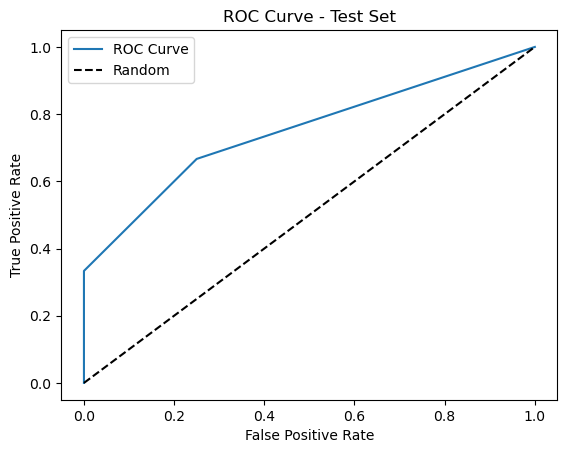

In [26]:
# Plot ROC curve for test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_proba)
plt.plot(fpr_test, tpr_test, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend()
plt.show()

In [28]:
# Calculate the confusion matrix for test set
cm_test = confusion_matrix(y_test, y_test_pred)

# Create a figure and axis for test set
fig, ax_test = plt.subplots()
im_test = ax_test.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
cbar_test = ax_test.figure.colorbar(im_test, ax=ax_test)
ax_test.set(xticks=np.arange(cm_test.shape[1]),
            yticks=np.arange(cm_test.shape[0]),
            xlabel='Predicted label',
            ylabel='True label',
            title='Confusion Matrix - Test Set')
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        ax_test.text(j, i, format(cm_test[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm_test[i, j] > cm_test.max() / 2 else "black")
plt.show()

ValueError: Classification metrics can't handle a mix of binary and continuous targets

### Logistic Regression on Scaled Data

#### Scaling the Data

In [ ]:
def scaling(x, y):
    scale = preprocessing.RobustScaler()
    x_t1 = scale.fit_transform(x, y)
    x_t1 = pd.DataFrame(x_t1, columns = x.columns)
    
    scale = preprocessing.StandardScaler()
    x_t2 = scale.fit_transform(x_t1, y)
    x_t2 = pd.DataFrame(x_t2, columns = x.columns)
    
    return(x_t2)

In [ ]:
x_train_scaled = scaling(x_train_sm, y_train_sm)
x_test_scaled = scaling(x_test, y_test)
x_val_scaled = scaling(x_val, y_val)

#### Setting the regularisation parameter

In [ ]:
# Define the range of regularization parameters to explore
reg_scaled = [0.001, 0.01, 0.1, 1, 10]

#### Fitting the train data 

In [ ]:
# Perform hyperparameter tuning with cross-validation
logreg_cv_scaled = LogisticRegressionCV(Cs = reg_scaled, cv = 10)

logreg_cv_scaled.fit(x_train_scaled, y_train_sm.values.ravel())

In [ ]:
# Get the best regularization parameter found during cross-validation
best_reg_param = logreg_cv_scaled.C_[0]

print("Best Regularization Parameter:", best_reg_param)

#### Predicting the values for the validation dataset

In [ ]:
# Predict using the best model on the validation data

y_val_pred = logreg_cv_scaled.predict(x_val_scaled)

In [ ]:
# Evaluate model performance on the validation data

val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)
print("Validation RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_val_pred)))

# Calculate predicted probabilities for the bad class
y_val_prob = logreg_cv_scaled.predict_proba(x_val_scaled)[:, 1]

In [ ]:
# Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)

# Calculate the area under the ROC curve
auc = roc_auc_score(y_val, y_val_prob)

# Print the ROC AUC
print("ROC AUC:", auc)

In [ ]:
# Plot the ROC curve
plt.plot(fpr, tpr, label = 'ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the confusion matrix as an image
im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)

# Add colorbar
cbar = ax.figure.colorbar(im, ax = ax)

# Set labels, title, and ticks
ax.set(xticks = np.arange(cm.shape[1]),
       yticks = np.arange(cm.shape[0]),
       xlabel = 'Predicted label',
       ylabel = 'True label',
       title = 'Confusion Matrix')

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha = "center", va = "center",
                color="white" if cm[i, j] > cm.max() / 2 else "black")

# Display the plot
plt.show()

cm = classification_report(y_val, y_val_pred)

print(cm)

#### Predicting values for test data

In [ ]:
# Predict using the best model on the test data

y_test_pred = logreg_cv_scaled.predict(x_test_scaled)

In [ ]:
# Evaluate model performance on the test data

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)
print("Validation RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

# Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Calculate the area under the ROC curve
auc = roc_auc_score(y_test, y_test_pred)

# Print the ROC AUC and confusion matrix
print("ROC AUC:", auc)

In [ ]:
# Plot the ROC curve
plt.plot(fpr, tpr, label = 'ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the confusion matrix as an image
im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)

# Add colorbar
cbar = ax.figure.colorbar(im, ax = ax)

# Set labels, title, and ticks
ax.set(xticks = np.arange(cm.shape[1]),
       yticks = np.arange(cm.shape[0]),
       xlabel = 'Predicted label',
       ylabel = 'True label',
       title = 'Confusion Matrix')

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha = "center", va = "center",
                color="white" if cm[i, j] > cm.max() / 2 else "black")

# Display the plot
plt.show()

cm = classification_report(y_test, y_test_pred)

print(cm)